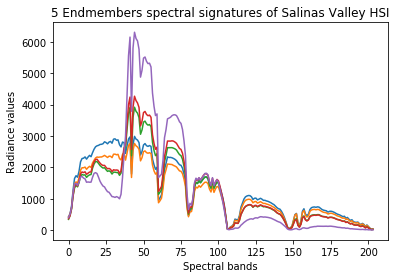

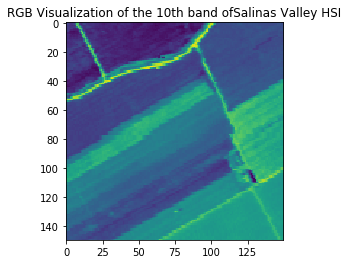

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt

%matplotlib inline
Salinas = sio.loadmat('Salinas_hyperspectral.mat')
gt = sio.loadmat('Salina_ground_truth.mat')
HSI = Salinas['Salinas_Image'] #Salinas HSI : 150x150x204
endmembers = Salinas['Salinas_endmembers'] # Endmember's matrix: 204x5

fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('5 Endmembers spectral signatures of Salinas Valley HSI')
plt.show()

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band ofSalinas Valley HSI')
plt.show()

### Part 1

#### (a) Unconstrained LS Method

In [2]:
from cvxopt import solvers,matrix
solvers.options['show_progress'] = False

abmap_a = np.zeros((150,150,5))

LS1 = []
rec_error_a = []

for i in range(0,150):
    for j in range(0,150):
        if gt['Labels'][i,j] == 0:
            continue
        else:
            #Thetas
            y = HSI[i,j,:]
            theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(endmembers.T,endmembers)),endmembers.T),y)
            theta_final = np.array(theta).flatten('F')
            LS1.append(theta_final)
            
            #abundance map
            for d in range(0,5):
                abmap_a[i,j,d] = theta_final[d]
                
            #reconstruction error
            rec_error_a.append((y-endmembers@theta_final).T@(y-endmembers@theta_final))
            
LS1[0:5]

[array([-2.0476908 ,  2.37828022, -3.61389601,  3.48091171,  0.9521294 ]),
 array([-2.02718029,  2.36645527, -3.50114612,  3.32728818,  1.00404199]),
 array([-1.98960623,  2.32538957, -3.51938021,  3.33350798,  1.03163312]),
 array([-1.93324068,  2.22159289, -3.36060187,  3.26240975,  0.99061242]),
 array([-2.01257597,  2.35496834, -3.45855294,  3.29048148,  1.00554067])]

##### (i) Abundance maps for the LS method

No handles with labels found to put in legend.


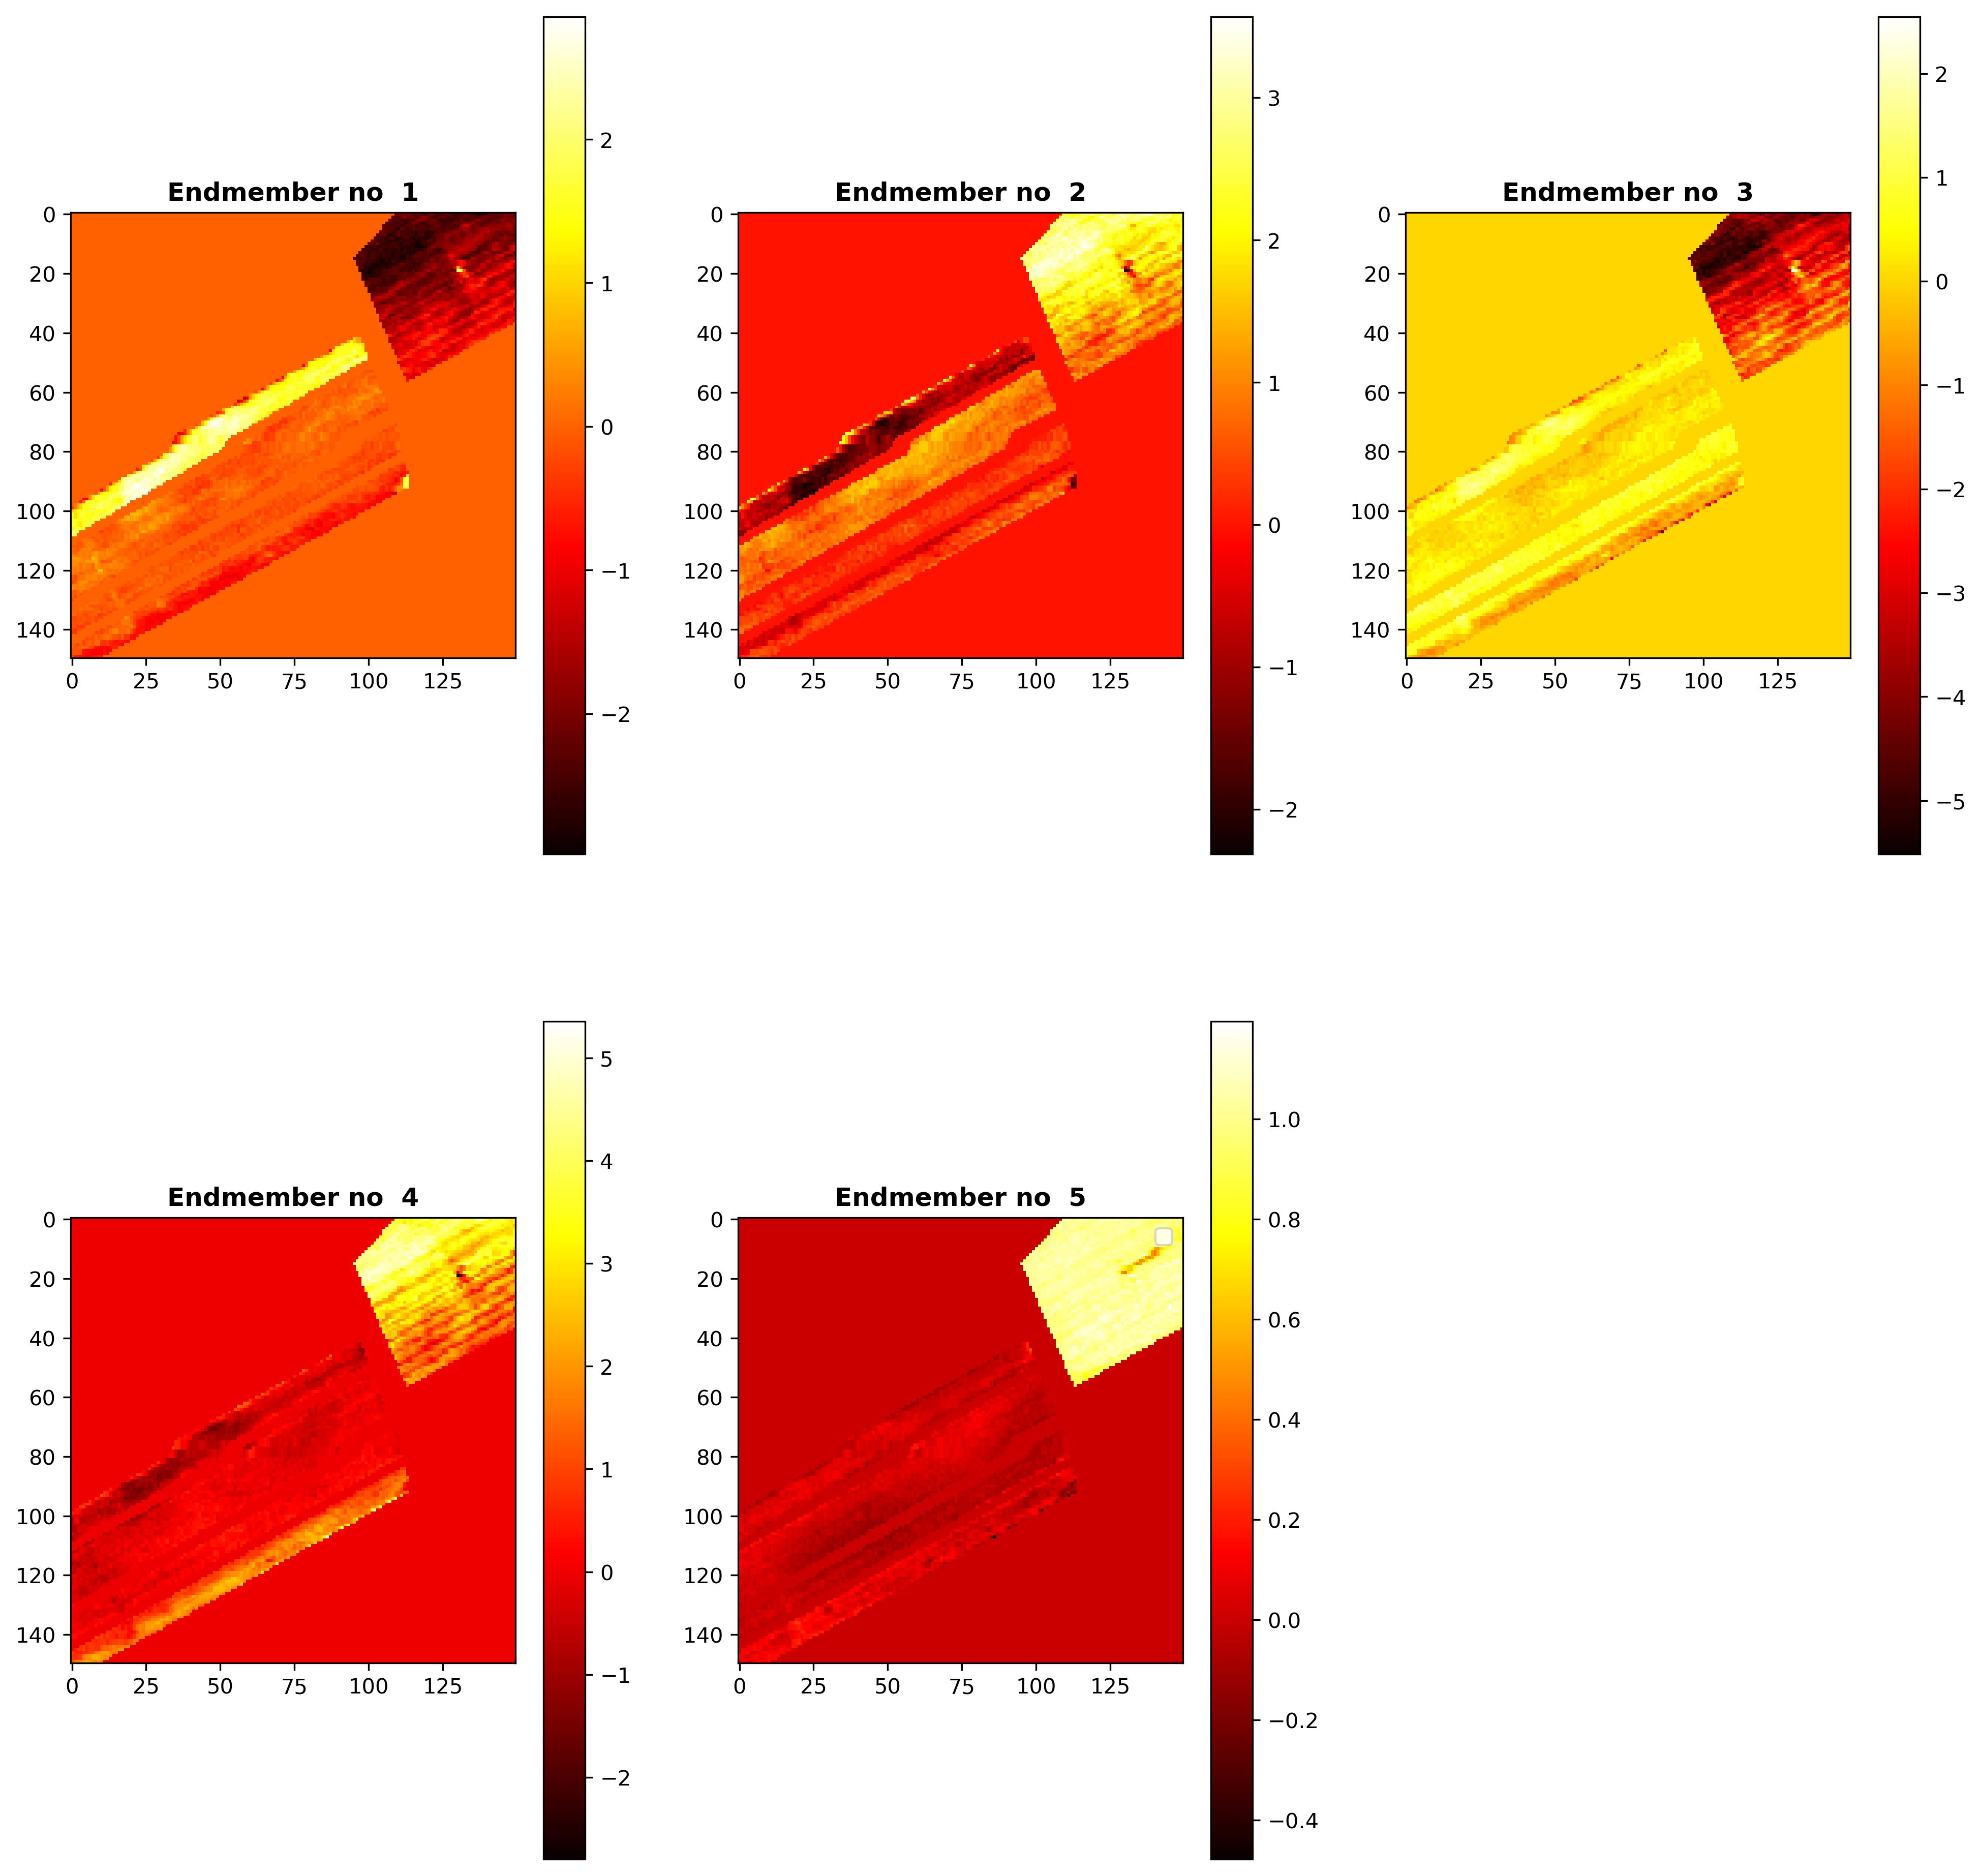

In [3]:
fig=plt.figure(figsize=(16, 16), dpi= 300, facecolor='w', edgecolor='k')

for i in range(0,5):
    plt.subplot(2,3,i+1)
    plt.imshow(abmap_a[:,:,i], cmap='hot')
    plt.title('Endmember no  '+str(i+1), fontweight="bold")
    plt.colorbar()
plt.legend()
plt.show()

##### (ii) Reconstruction error for the LS method

In [4]:
print('The reconstruction error is: ',round(np.mean(np.sqrt(rec_error_a)), 2))

The reconstruction error is:  338.25


#### (b) LS Method under the Sum-to-one constraint

In [5]:
LS2 = []

A = matrix([1.0,1.0,1.0,1.0,1.0], (1,5))
b = matrix(1.0)
Q = matrix(2*endmembers.T@endmembers)
abmap_b = np.zeros((150,150,5))

rec_error_b = []

for i in range(0,150):
    for j in range(0,150):
        if gt['Labels'][i,j] == 0:
            continue
        else:
            #thetas
            y = HSI[i,j,:]
            p = matrix(-2*y.T@endmembers)
            theta = solvers.qp(Q,p,A=A,b=b)['x']
            theta_final = np.array(theta).flatten('F')
            LS2.append(theta_final)
            
            #abundance map
            for d in range(0,5):
                abmap_b[i,j,d] = theta[d]
            
            #reconstruction error
            rec_error_b.append(np.dot((y - np.dot(endmembers,theta_final)).T, (y - np.dot(endmembers,theta_final))))
            
print(LS2[0])

[-1.12453511  1.04098885 -3.65108506  3.88493216  0.84969916]


##### Abundance map for the LS method imposing the sum-to one constraint

No handles with labels found to put in legend.


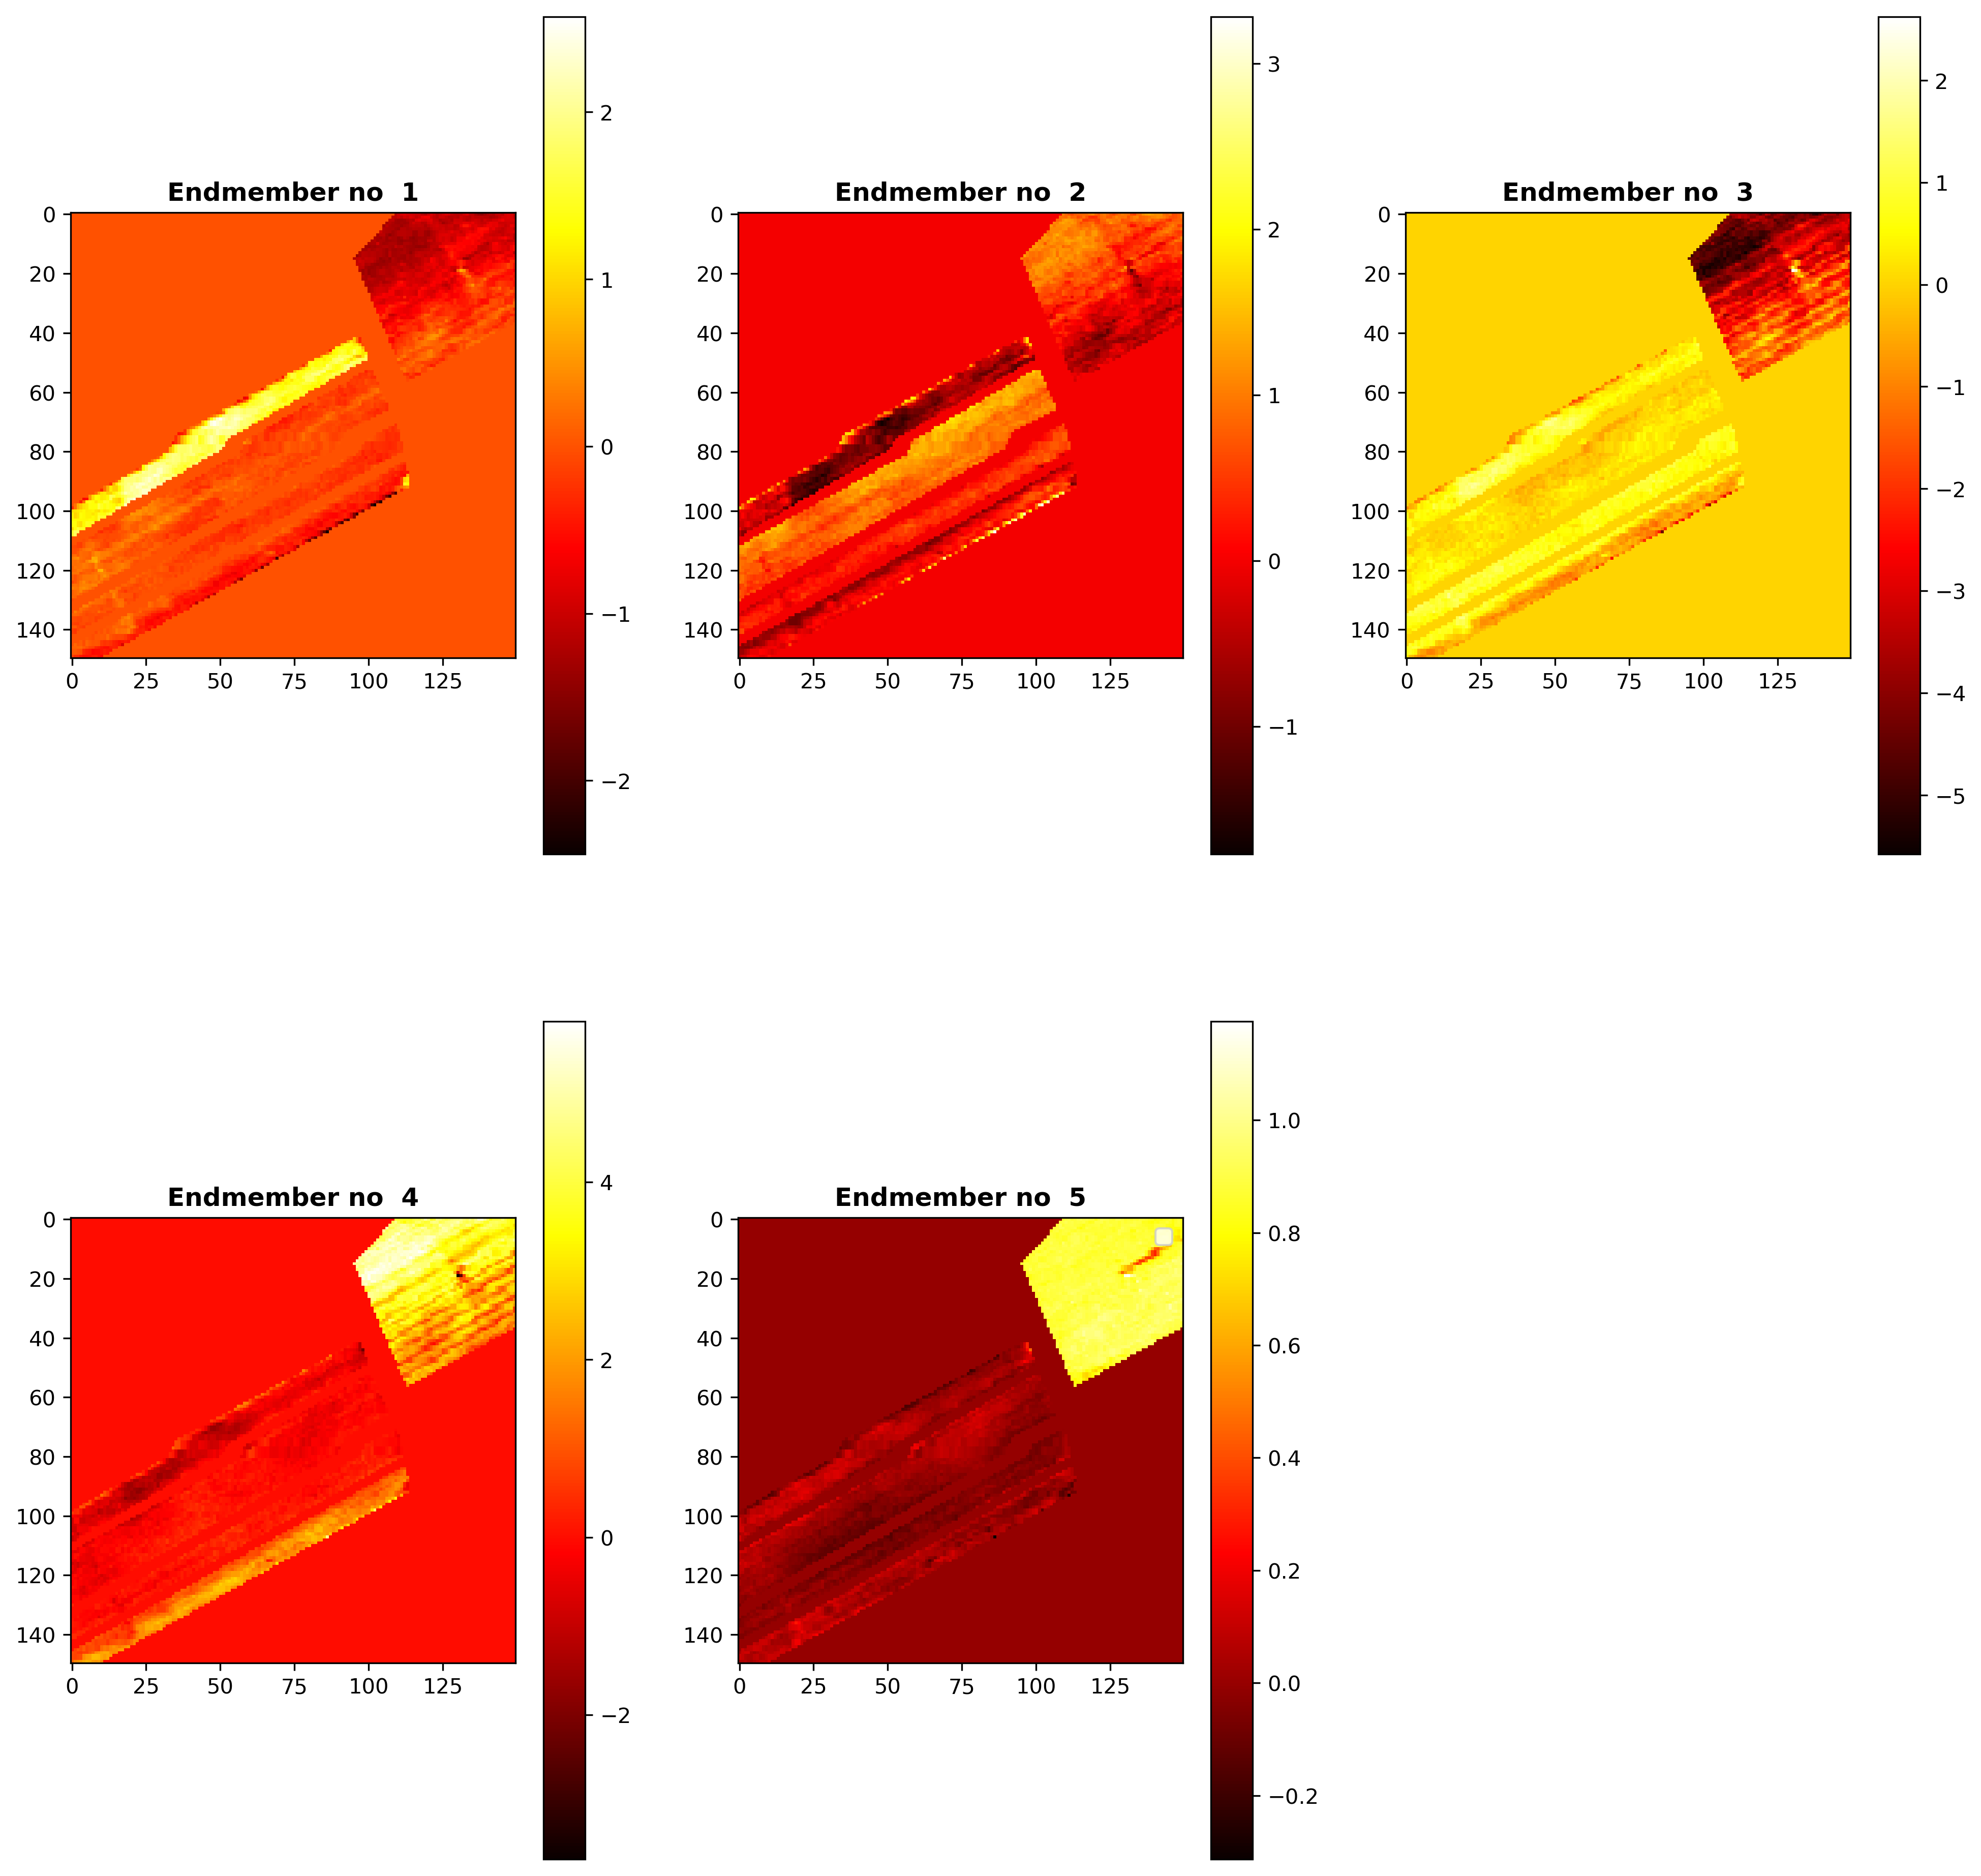

In [6]:
fig=plt.figure(figsize=(16, 16), dpi= 300, facecolor='w', edgecolor='k')

for i in range(0,5):
    plt.subplot(2,3,i+1)
    plt.imshow(abmap_b[:,:,i], cmap='hot')
    plt.title('Endmember no  '+str(i+1), fontweight="bold")
    plt.colorbar()
plt.legend()
plt.show()

##### (ii) Reconstruction error for the LS method imposing the sum-to one constraint

In [8]:
print('The reconstruction error is: ',round(np.mean(np.sqrt(rec_error_b)), 2))

The reconstruction error is:  402.99


##### (c) LS Method under the Non-negativity constraint

In [9]:
LS3 = []

G = matrix(-1*np.identity(5))
h = matrix([0.0,0.0,0.0,0.0,0.0])
Q = matrix(2*endmembers.T@endmembers)
abmap_c = np.zeros((150,150,5))

rec_error_c = []

for i in range(0,150):
    for j in range(0,150):
        if gt['Labels'][i,j] == 0:
            continue
        else:
            #thetas
            y = HSI[i,j,:]
            p = matrix(-2*y.T@endmembers)
            theta = scipy.optimize.nnls(endmembers, y)[0]
            theta_final = np.array(theta).flatten('F')
            LS3.append(theta)
            
            #abundance map
            for d in range(0,5):
                abmap_c[i,j,d] = theta_final[d]
                
            #reconstruction error
            rec_error_c.append((y-endmembers@theta_final).T@(y-endmembers@theta_final))
            
print(LS3[0]) 

[ 0.          0.          0.          0.          1.11286066]


##### Abundance map for the LS method imposing the non-negativity contraint

No handles with labels found to put in legend.


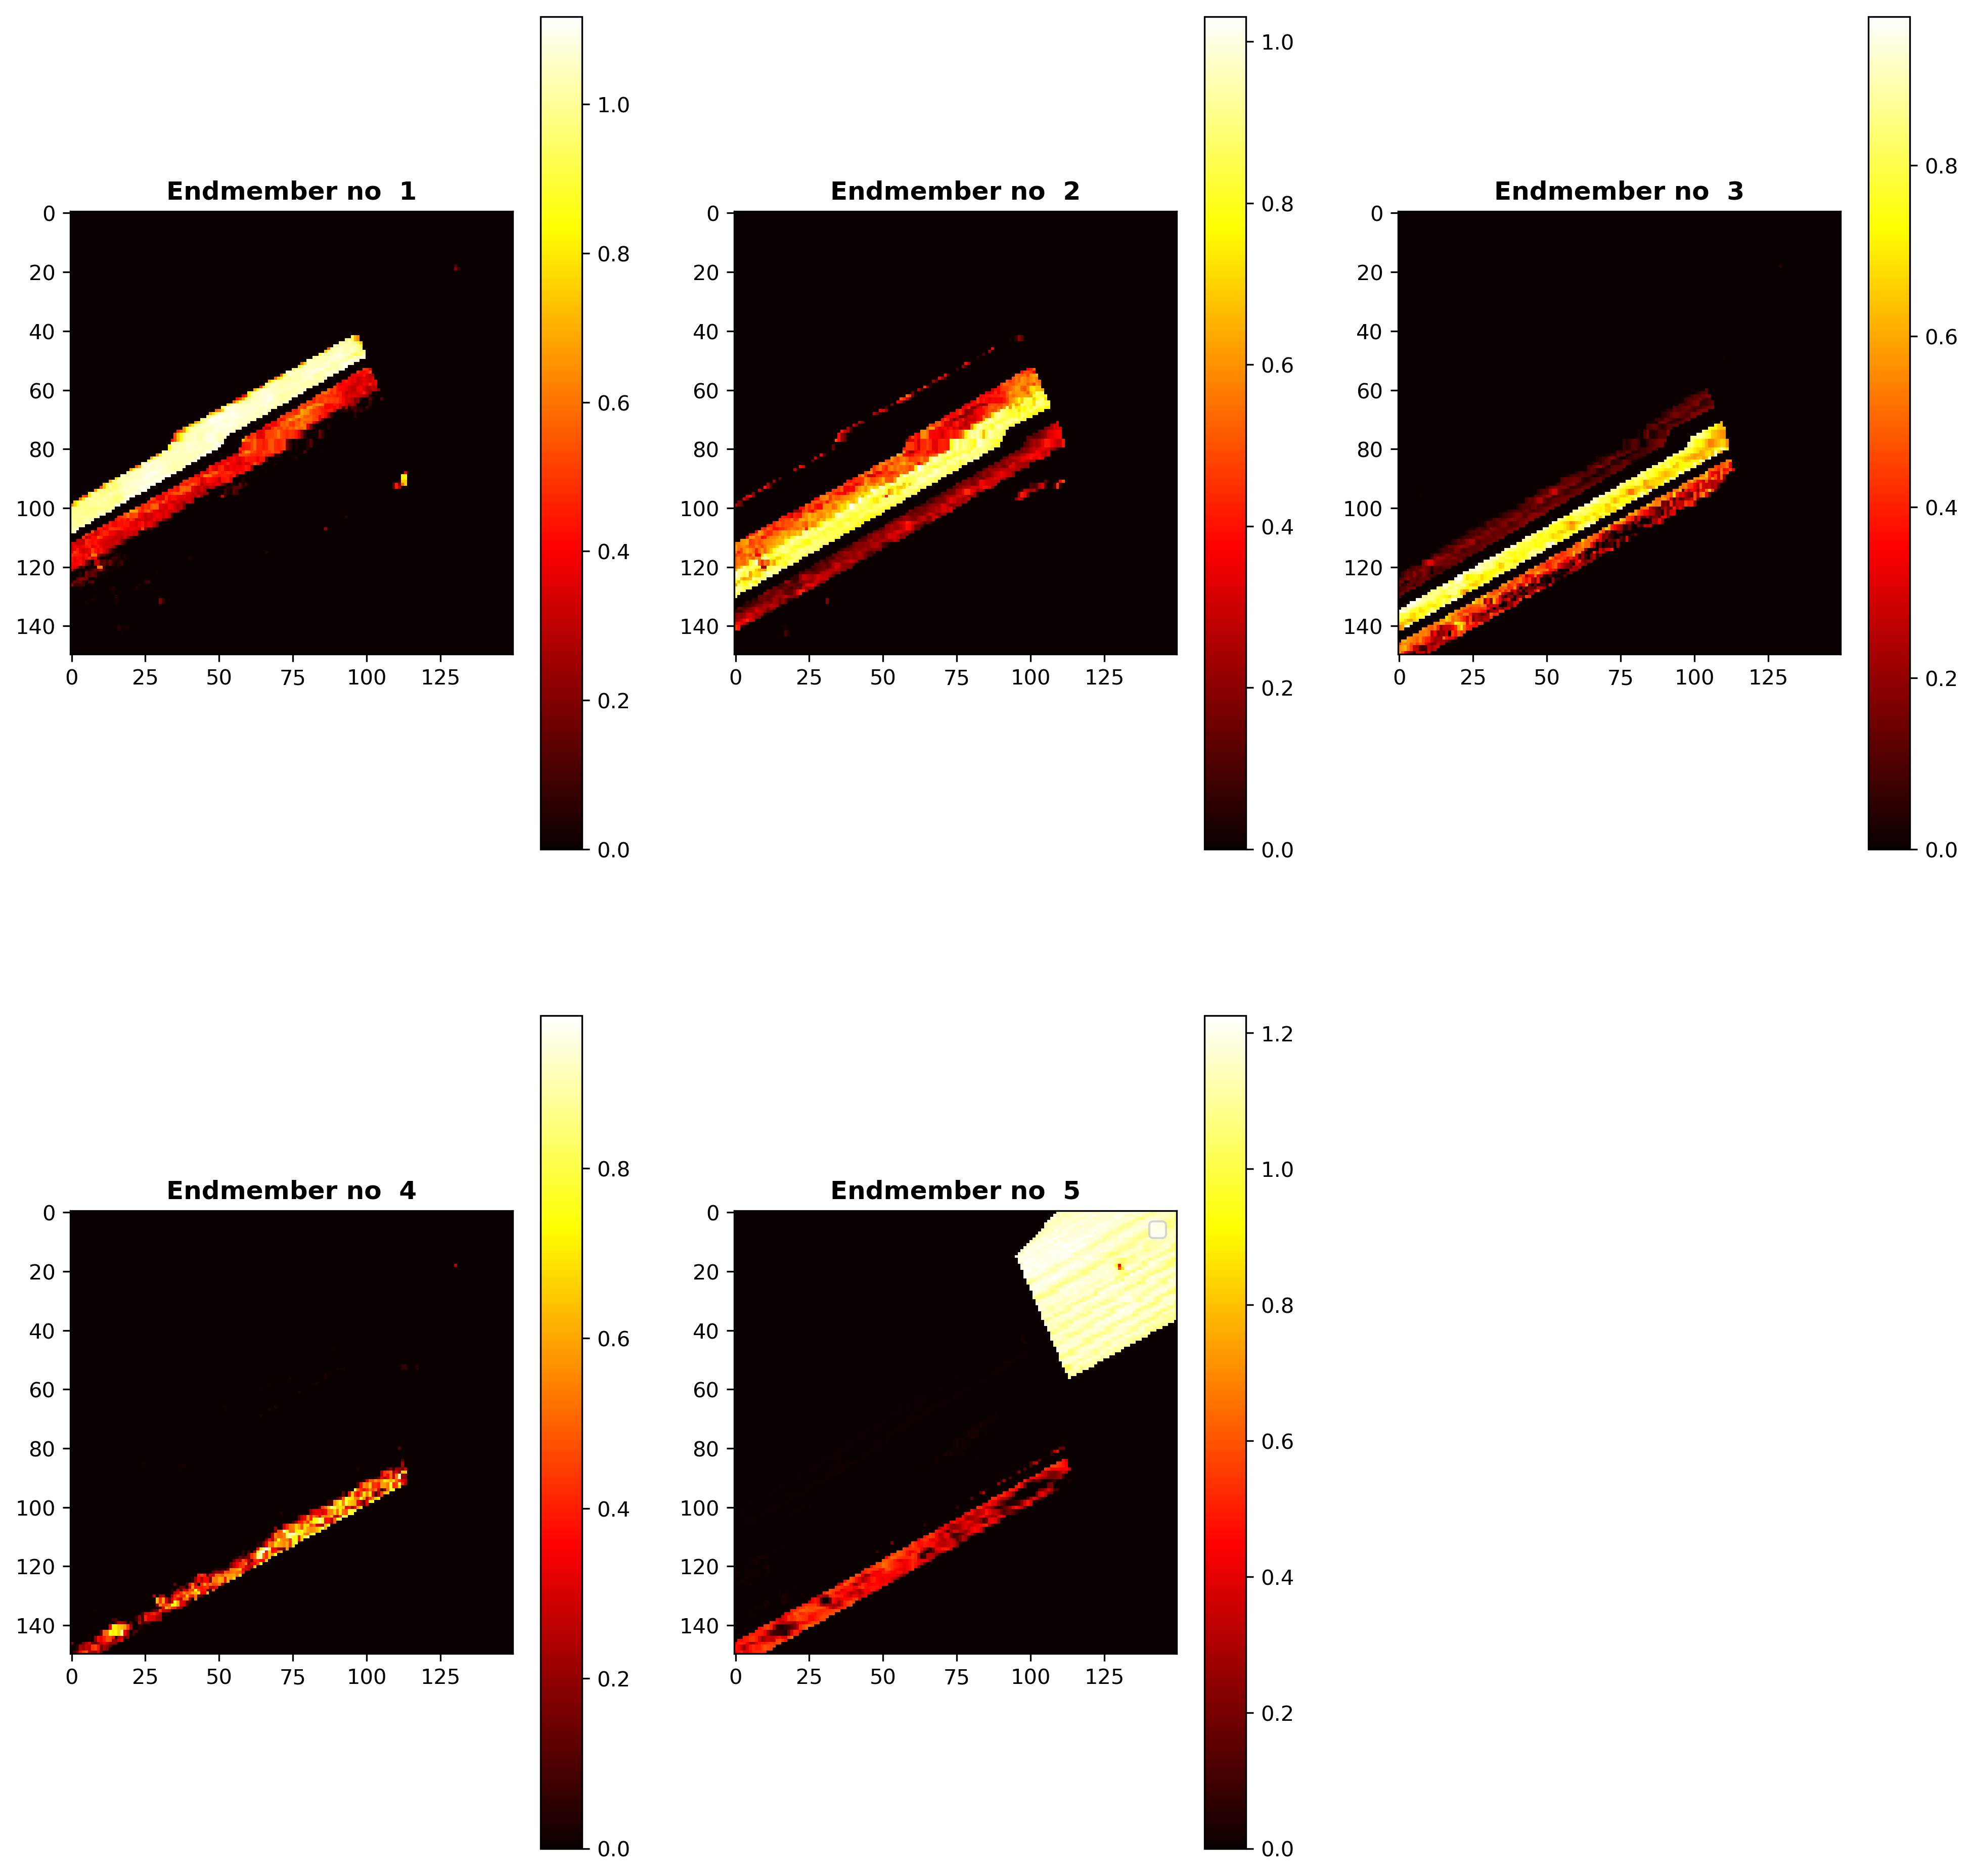

In [10]:
fig=plt.figure(figsize=(16, 16), dpi= 300, facecolor='w', edgecolor='k')

for i in range(0,5):
    plt.subplot(2,3,i+1)
    plt.imshow(abmap_c[:,:,i], cmap='hot')
    plt.title('Endmember no  '+str(i+1), fontweight="bold")
    plt.colorbar()
plt.legend()
plt.show()

##### (ii) Reconstruction error for the LS method imposing the non-negativity contraint

In [11]:
print('The reconstruction error is: ',round(np.mean(np.sqrt(rec_error_c)), 2))

The reconstruction error is:  832.11


##### (d) LS Method under the sum to one and non-negativity constraints

In [12]:
LS4 = []

A = matrix([1.0,1.0,1.0,1.0,1.0], (1,5))
b = matrix(1.0)
G = matrix(-1*np.identity(5))
h = matrix([0.0,0.0,0.0,0.0,0.0])
Q = matrix(2*endmembers.T@endmembers)
abmap_d = np.zeros((150,150,5))

rec_error_d = []

for i in range(0,150):
    for j in range(0,150):
        if gt['Labels'][i,j] == 0:
            continue
        else:
            #thetas
            y = HSI[i,j,:]
            p = matrix(-2*y.T@endmembers)
            theta = solvers.qp(Q,p,A=A,b=b,G=G,h=h)['x']
            theta_final = np.array(theta).flatten('F')
            LS4.append(theta_final)
            
            #abundance map
            for d in range(0,5):
                abmap_d[i,j,d] = theta_final[d]
                
            #reconstruction error
            rec_error_d.append((y-endmembers@theta_final).T@(y-endmembers@theta_final))
            
print(LS4[0])

[  2.19813173e-07   2.82590882e-11   2.79686952e-10   5.94240663e-08
   9.99999720e-01]


##### Abundance map for the LS method imposing the sum-to one and non negativity constraints

No handles with labels found to put in legend.


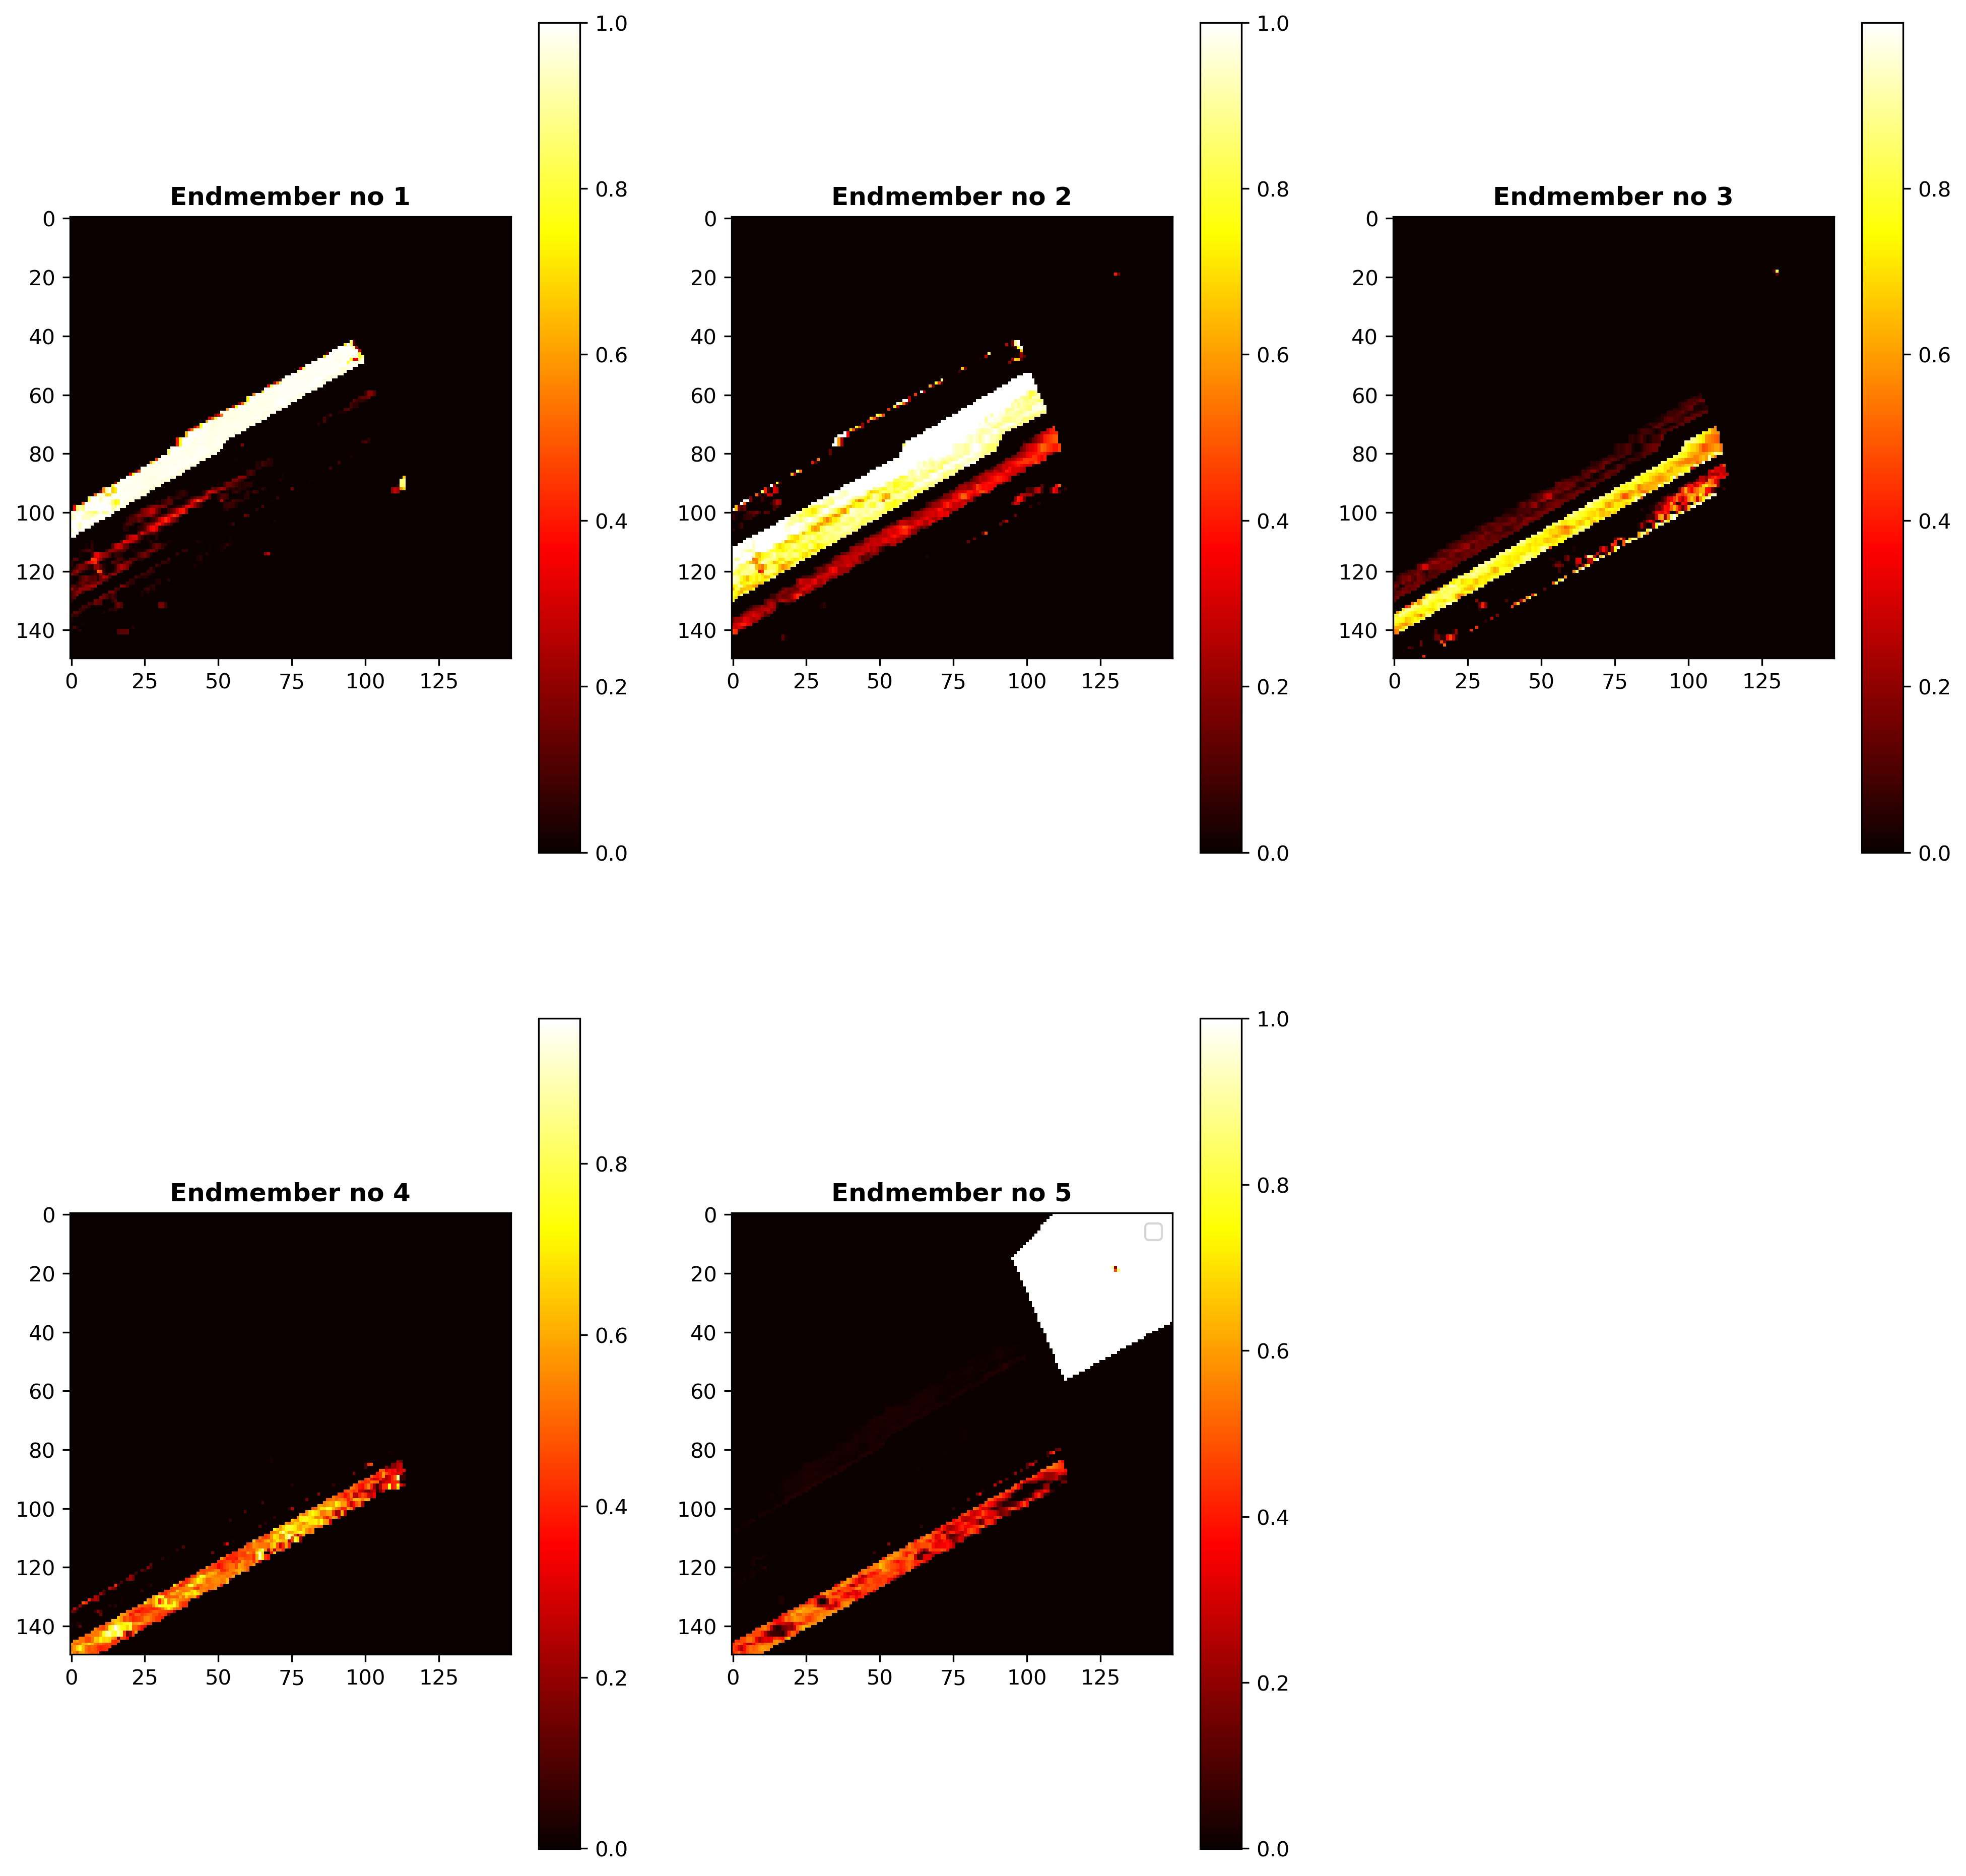

In [13]:
fig=plt.figure(figsize=(16, 16), dpi= 300, facecolor='w')

for i in range(0,5):
    plt.subplot(2,3,i+1)
    plt.imshow(abmap_d[:,:,i], cmap='hot')
    plt.title('Endmember no '+str(i+1), fontweight="bold")
    plt.colorbar()
plt.legend()
plt.show()

##### Reconstruction Error

In [14]:
print('The reconstruction error is: ',round(np.mean(np.sqrt(rec_error_d)), 2))

The reconstruction error is:  1961.31


#### (B)

Its clear that the method that includes both the sum-to-one and non negativity constraints yields the greatest reconstruction error. This is to be expected since unconstrained optimization yields the true optimal value. However that value has no physical interpretation in this specific use case since $\theta_i$ represents a percentage and thus has to be non-negative and sum to one. Now lets compare the pixel classes to the abundance maps of the LS method with both constraints:

No handles with labels found to put in legend.


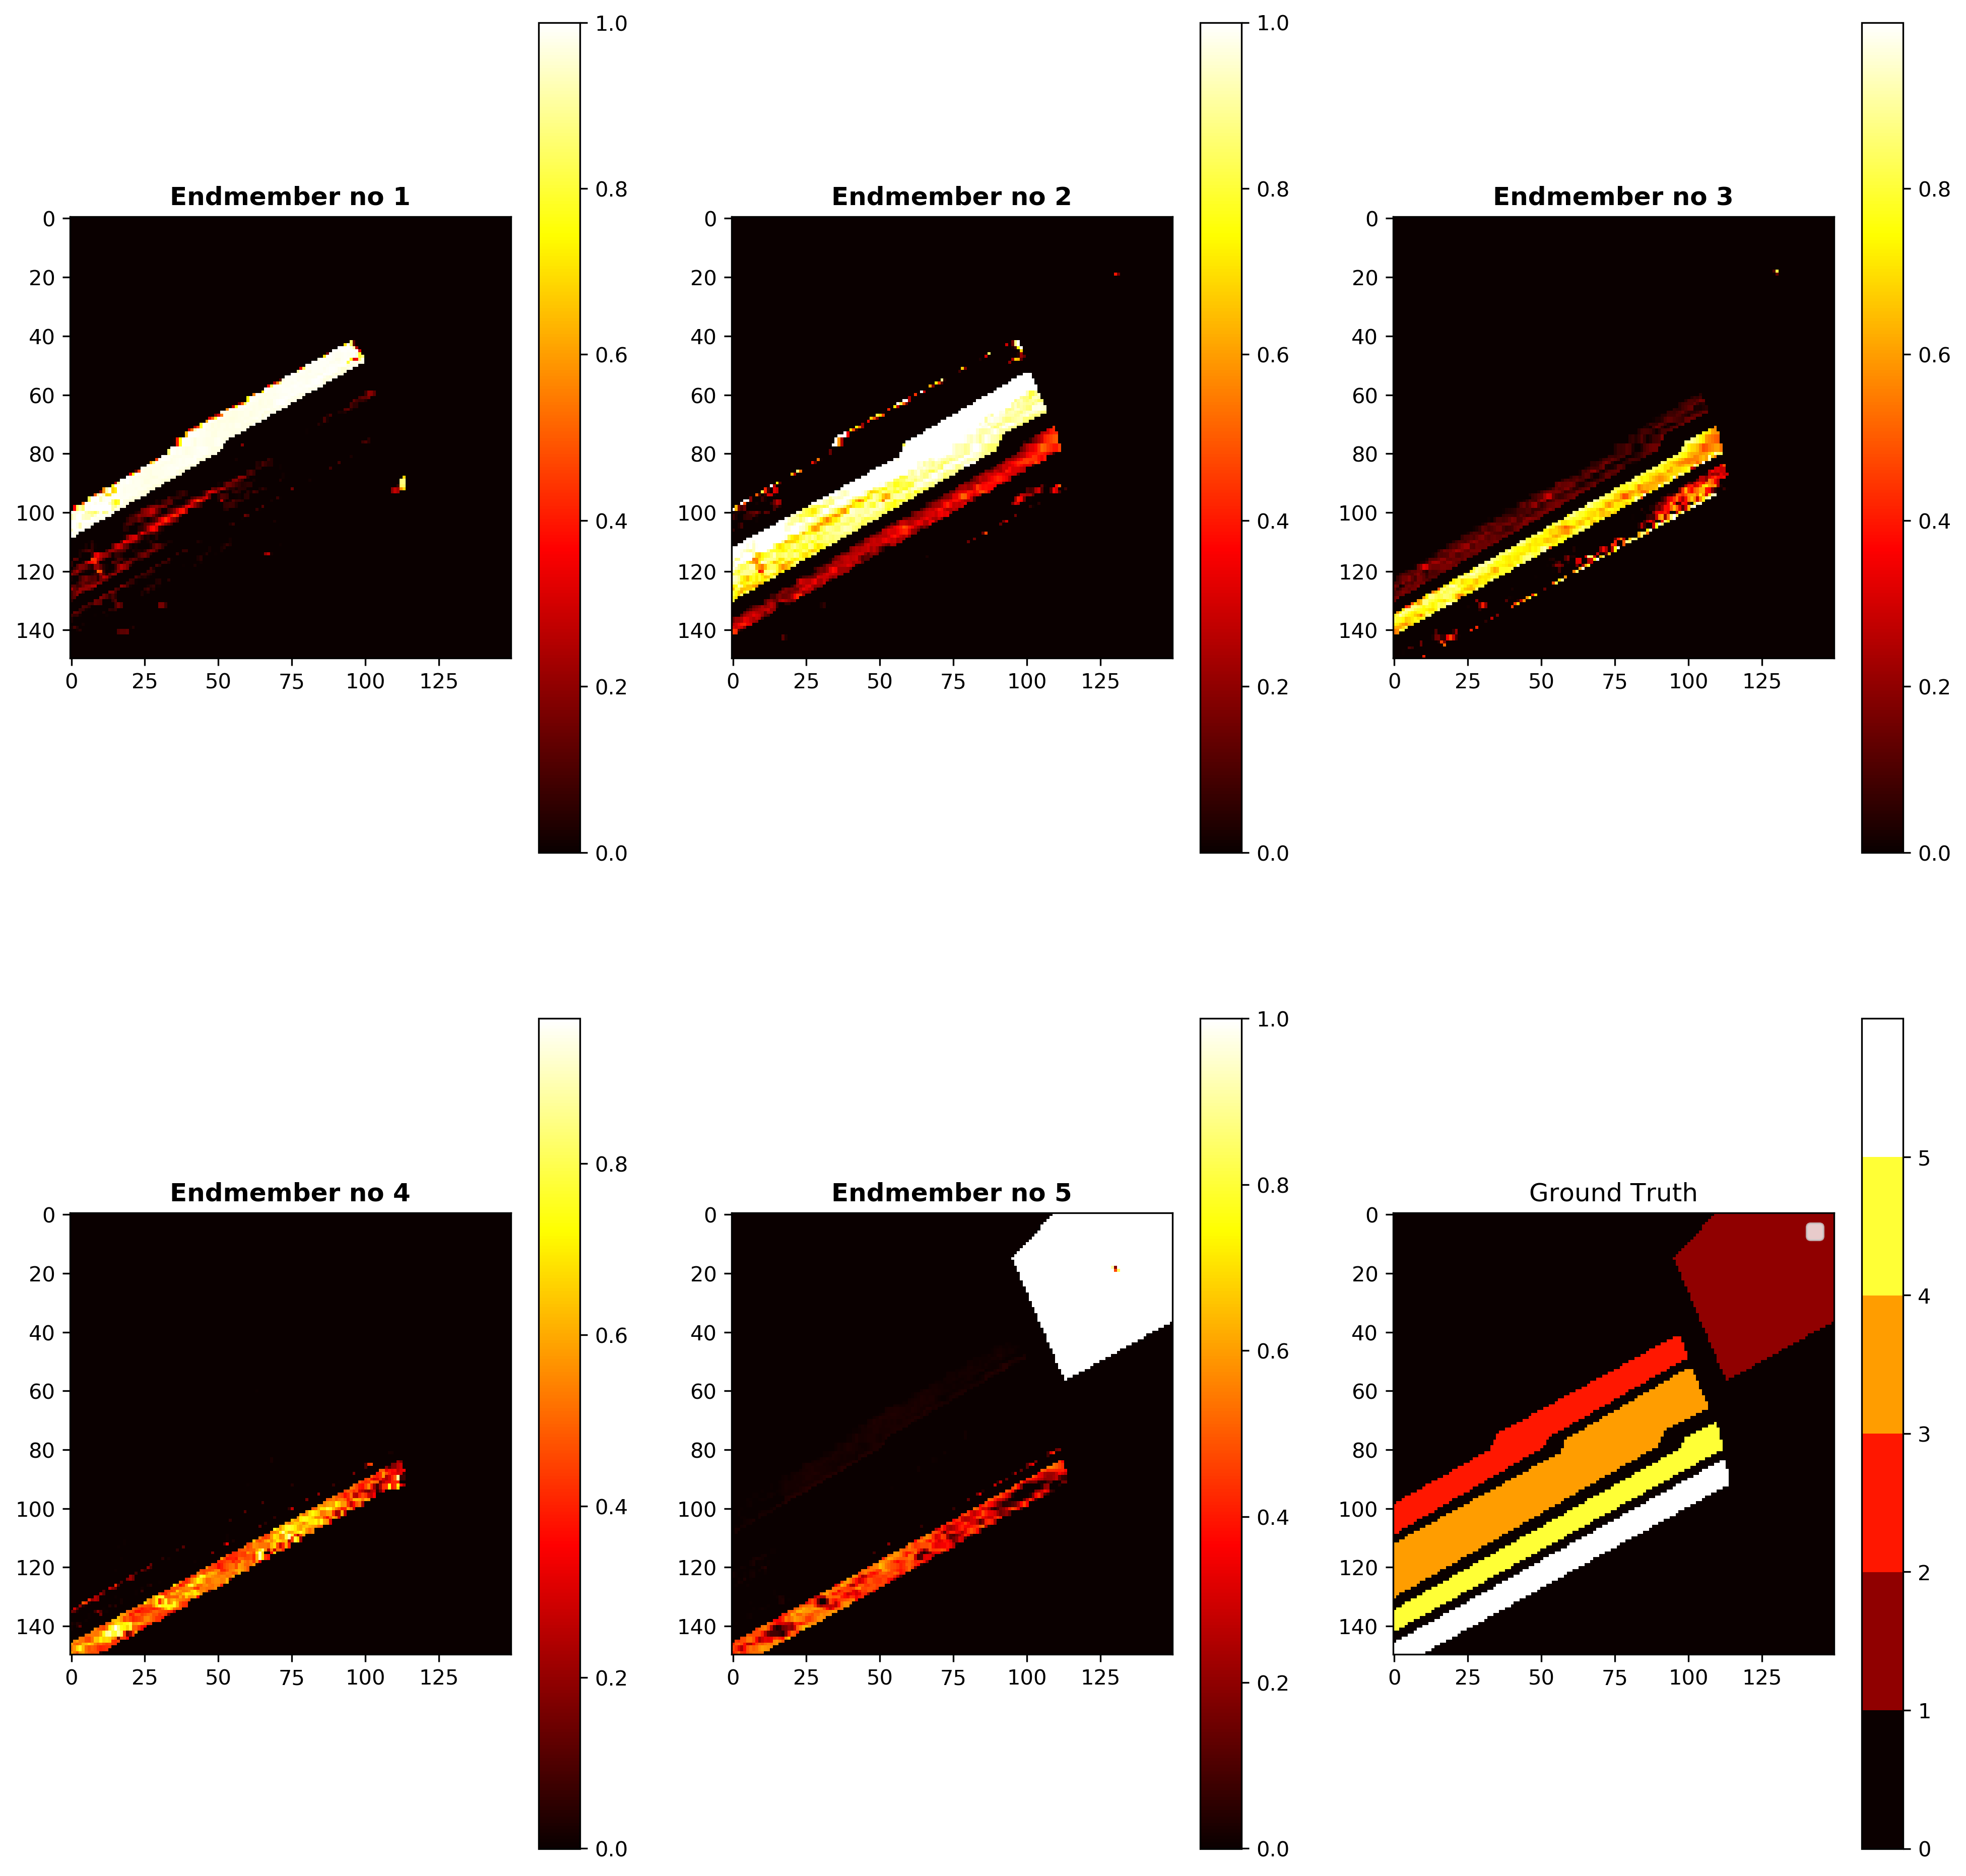

In [36]:
def plot_final_maps():

    from matplotlib.colors import BoundaryNorm

    fig=plt.figure(figsize=(16, 16), dpi= 300, facecolor='w')

    cmap = plt.cm.hot
    norm = BoundaryNorm(np.arange(0,7,1),cmap.N)

    for i in range(0,5):
        plt.subplot(2,3,i+1)
        plt.imshow(abmap_d[:,:,i], cmap='hot')
        plt.title('Endmember no '+str(i+1), fontweight="bold")
        plt.colorbar()

    plt.subplot(2,3,6)
    plt.imshow(gt['Labels'], cmap='hot', norm = norm)
    plt.title('Ground Truth')
    plt.colorbar(ticks=np.linspace(0,5,6))
    plt.legend()
    plt.show()
    
plot_final_maps()

So the conclusion is that for the area marked as 1 in the ground truth picture, the fifth endmember exists at a higher concentration than the rest, while it also exists in the area marked as 5. However the area marked as 5 also has a high concentration of the 4th endmember. For the areas marked as 4,3 and 2, the endmembers 3,2 and 1 respectively dominate the rest. Its clear that we could derive this conlusion from both methods that include the non-negativity constraint, while the ones that don't include it, produce an image that is not so accurate due to the deviation from the nature of the problem.

### Part 2

#### (i)

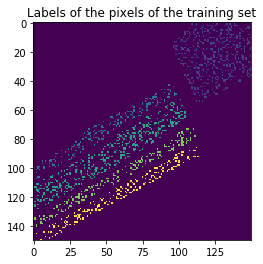

In [15]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels.mat')
Training_Set = (np.reshape(Salinas_labels['Training_Set'],(150,150))).T
Test_Set = (np.reshape(Salinas_labels['Test_Set'],(150,150))).T
Operational_Set = (np.reshape(Salinas_labels['Operational_Set'],(150,150))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

##### Data Preprocessing

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

train_length, test_length, operational_length = 0,0,0

for i in range(0,150):
    for j in range(0,150):
        if Training_Set[i,j] != 0:
            train_length += 1
        if Test_Set[i,j] != 0:
            test_length += 1
        if Operational_Set[i,j] != 0:
            operational_length += 1

train_data = np.zeros((train_length,204))
test_data = np.zeros((test_length,204))
operational_data = np.zeros((operational_length,204))

train_labels = np.zeros((train_length,))
test_labels = np.zeros((test_length,))
operational_labels = np.zeros((operational_length,))

train_count, test_count, operational_count = 0,0,0

for i in range(0,150):
    for j in range(0,150):        
        if (Training_Set[i,j] != 0) & (train_count <= train_length):
            train_data[train_count,:] = HSI[i,j,:]
            train_labels[train_count] = Training_Set[i,j]
            train_count += 1
        if (Test_Set[i,j] != 0) & (test_count <= test_length):
            test_data[test_count,:] = HSI[i,j,:]
            test_labels[test_count] = Test_Set[i,j]
            test_count += 1
        if (Operational_Set[i,j] != 0) & (operational_count <= operational_length):
            operational_data[operational_count,:] = HSI[i,j,:]
            operational_labels[operational_count] = Operational_Set[i,j]
            operational_count += 1


* ##### Naive Bayes Classifier

##### 1. Training

In [17]:
model = GaussianNB()

score_m = str(100-round(np.mean(cross_val_score(model, train_data, train_labels, cv =10)*100),2)) + '%'
score_sd = str(round(np.std(cross_val_score(model, train_data, train_labels, cv =10)*100),2)) + '%'

print('Estimated Validation Error: ' + score_m +'\n' + 'Standard Deviation of Validation Error: ' + score_sd)

Estimated Validation Error: 1.79%
Standard Deviation of Validation Error: 1.38%


##### 2. Evaluation

In [18]:
NB = model.fit(X = train_data, y = train_labels)
pred = NB.predict(test_data)

conf = confusion_matrix(y_pred = pred,y_true = test_labels)
conf

array([[652,   0,   0,   0,   0],
       [  0, 333,   8,   0,   1],
       [  0,   1, 548,   0,   0],
       [  0,   0,   0, 267,   8],
       [  0,   2,   0,  14, 331]], dtype=int64)

In [20]:
print('Test Accuracy: ',str(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))+'%')

Test Accuracy:  98.43%


##### 3. Operational

In [21]:
pred = NB.predict(operational_data)

conf = confusion_matrix(y_pred = pred,y_true = operational_labels)
conf

array([[1156,    0,    0,    0,    1],
       [   0,  521,   11,    0,    2],
       [   0,    8,  950,    0,    0],
       [   0,    0,    0,  440,   11],
       [   0,    4,    3,   24,  478]], dtype=int64)

In [22]:
print('Operational Accuracy: ',str(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))+'%')

Operational Accuracy:  98.23%


The Naive Bayes classifier seems to perform really good with high accuracy. It seems to find it harder to separate classes 4 and 5 but the number of misclassifications is almost insignificant.

* ##### K-Nearest Neibors Classifier

##### 1. Training

In [23]:
model = KNeighborsClassifier()

score_m = str(100-round(np.mean(cross_val_score(model, train_data, train_labels, cv =10)*100),2)) + '%'
score_sd = str(round(np.std(cross_val_score(model, train_data, train_labels, cv =10)*100),2)) + '%'

print('Estimated Validation Error: ' + score_m +'\n' + 'Standard Deviation of Validation Error: ' + score_sd)

Estimated Validation Error: 1.04%
Standard Deviation of Validation Error: 0.83%


##### 2. Evaluation

In [24]:
knn = model.fit(X = train_data, y = train_labels)
pred = knn.predict(test_data)

conf = confusion_matrix(y_pred = pred,y_true = test_labels)
conf

array([[652,   0,   0,   0,   0],
       [  0, 328,  14,   0,   0],
       [  0,   0, 549,   0,   0],
       [  0,   0,   0, 265,  10],
       [  0,   2,   0,  12, 333]], dtype=int64)

In [25]:
print('Test Accuracy: ',str(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))+'%')

Test Accuracy:  98.24%


##### 3. Operational

In [26]:
pred = knn.predict(operational_data)

conf = confusion_matrix(y_pred = pred,y_true = operational_labels)
conf

array([[1155,    0,    0,    0,    2],
       [   0,  523,   11,    0,    0],
       [   0,    0,  958,    0,    0],
       [   0,    0,    0,  438,   13],
       [   0,    4,    0,   23,  482]], dtype=int64)

In [27]:
print('Operational Accuracy: ',str(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))+'%')

Operational Accuracy:  98.53%


The K-Nearest Neibors classifier also performed well, again with some misclassifications between classes 4 and 5 and some of the class 2 which where predicted as class 3. But still the error is almost insignificant.

* ##### Minimum Euclidean Distance Classifier

##### 1 Implementation and Training

In [28]:
def min_dist_classifier(train, classes, test):
    
    dataset_length = test.shape[0]
    train_class_means = {}

    for i in range(1,6):
        train_class_means[i] = np.mean(train[np.where(classes == i)[0],:],0)

    EDtest_y = np.zeros((dataset_length, 1))

    for i in range(0, dataset_length):
        min_dist = 9999999
        pred_class = 0
        for j in range(1,6):
            dist = np.sqrt(np.linalg.norm(test[i,:] - train_class_means[j]))

            if dist < min_dist:
                min_dist = dist
                pred_class = j

        EDtest_y[i] = pred_class
    return(EDtest_y)

In [29]:
np.random.seed(3216)

split_rows = {}

rows = list(np.arange(train_length))

for i in range(1,11):
        if i != 10:
            split_rows[i] = list(np.random.choice(rows, round(train_length/10),replace = False))
            for j in split_rows[i]:
                rows.remove(j)
        else:
            split_rows[i] = rows
    
scores = []
for i in range(1,11):
    cross_val_train_data = np.delete(train_data, split_rows[i], axis=0)
    evaluation_test_data = train_data[split_rows[i],:]
    cross_val_train_labels = np.delete(train_labels, split_rows[i])
    evaluation_labels = train_labels[split_rows[i]]

    pred = min_dist_classifier(cross_val_train_data, cross_val_train_labels, evaluation_test_data)
    
    conf = confusion_matrix(y_pred = pred,y_true = evaluation_labels)

    score = np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))
                            
    scores.append(score)
    
score_m = str(100 -(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))) + '%'
score_sd = str(round(np.std(scores)*100,2)) + '%'

print('Estimated Validation Error: ' + score_m +'\n' + 'Standard Deviation of Validation Error: ' + score_sd)

Estimated Validation Error: 2.7%
Standard Deviation of Validation Error: 1.71%


##### 2. Evaluation

In [30]:
pred = min_dist_classifier(train_data, train_labels, test_data)

conf = confusion_matrix(y_pred = pred,y_true = test_labels)
conf

array([[652,   0,   0,   0,   0],
       [  0, 321,  21,   0,   0],
       [  0,   0, 549,   0,   0],
       [  0,   0,   0, 270,   5],
       [  0,   2,   0,  25, 320]], dtype=int64)

In [31]:
print('Test Accuracy: ',str(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))+'%')

Test Accuracy:  97.55%


##### 3. Operational

In [32]:
pred = min_dist_classifier(train_data, train_labels, operational_data)

conf = confusion_matrix(y_pred = pred,y_true = operational_labels)
conf

array([[1155,    0,    0,    1,    1],
       [   0,  505,   29,    0,    0],
       [   0,    0,  958,    0,    0],
       [   0,    0,    0,  446,    5],
       [   0,    4,    0,   61,  444]], dtype=int64)

In [33]:
print('Operational Accuracy: ',str(round(np.trace(conf)/(np.sum(np.sum(conf, axis = 0)))*100,2))+'%')

Operational Accuracy:  97.2%


#### (B)

All classifiers performed well. The out of sample error during cross validation is low in each case with a small standard deviation, showing that the classifiers did not overfit on the training set. That is later comfirmed by the high accuracy on the test set and even the operational set. From the confusion matrices we can see that the classes that were harder to distinguish were classes 4 and 5 since they are the ones with the most misclassifications. Also it seems that in every classifier there are some pixels that belong to the class 2 and are incorrectly classified as 3.

#### (C)

In order to use the Bayesian Classifier where the classes are modeled by normal distributions, we need to estimate the covariance matrix for the dataset. However the covariance matrix is an 204x204 matrix in this case and by constructing it we are estimating 204*(204-1)/2, that is approximately 20706 unique parameters with only 1444 data vectors. Thus we don't have enough data to accurately estimate all parameters. So the bayesian classifier where the classes are modeled by normal distributions could only be used in two cases, if we had lower dimensional data or if we had more data.

### Part 3

If we relate the classification and the regression results, its clear that there is a correlation. This is most obvious in the classes that are missclassified by most classifiers. More specifically the following cases stand out:

* In the classification results we can see that there are some data points from the class 2 that are incorrectly classified as class 3. Now if we check the abundance maps below, its clear that even though endmember 2 is mostly concentrated in the area of class 3, there are some pixels that imply a high concentration of it also in the area of class 2. So some misclassifications are to be expected, and indeed all classifiers failed to fully separate those classes.

* Following the same logic, its clear that endmember 3 is present in classes 4 and 5 so thats where the most misclassifications are expected to be. And indeed the most difficult classes to distinquish seem to be 4 and 5.

* Finally its clear that in class one the only endmember present with a very high concentration is endmember 5. So class one is expected to be successfully predicted by all classifiers. And indeed we can see in the confusion matrices that class 1 actually has the less misclassifications.

In conclusion, the regression and classification results seem to be correlated, and if the regression task is done right, then from its results we can get a general idea of what to expect from the classification task.

No handles with labels found to put in legend.


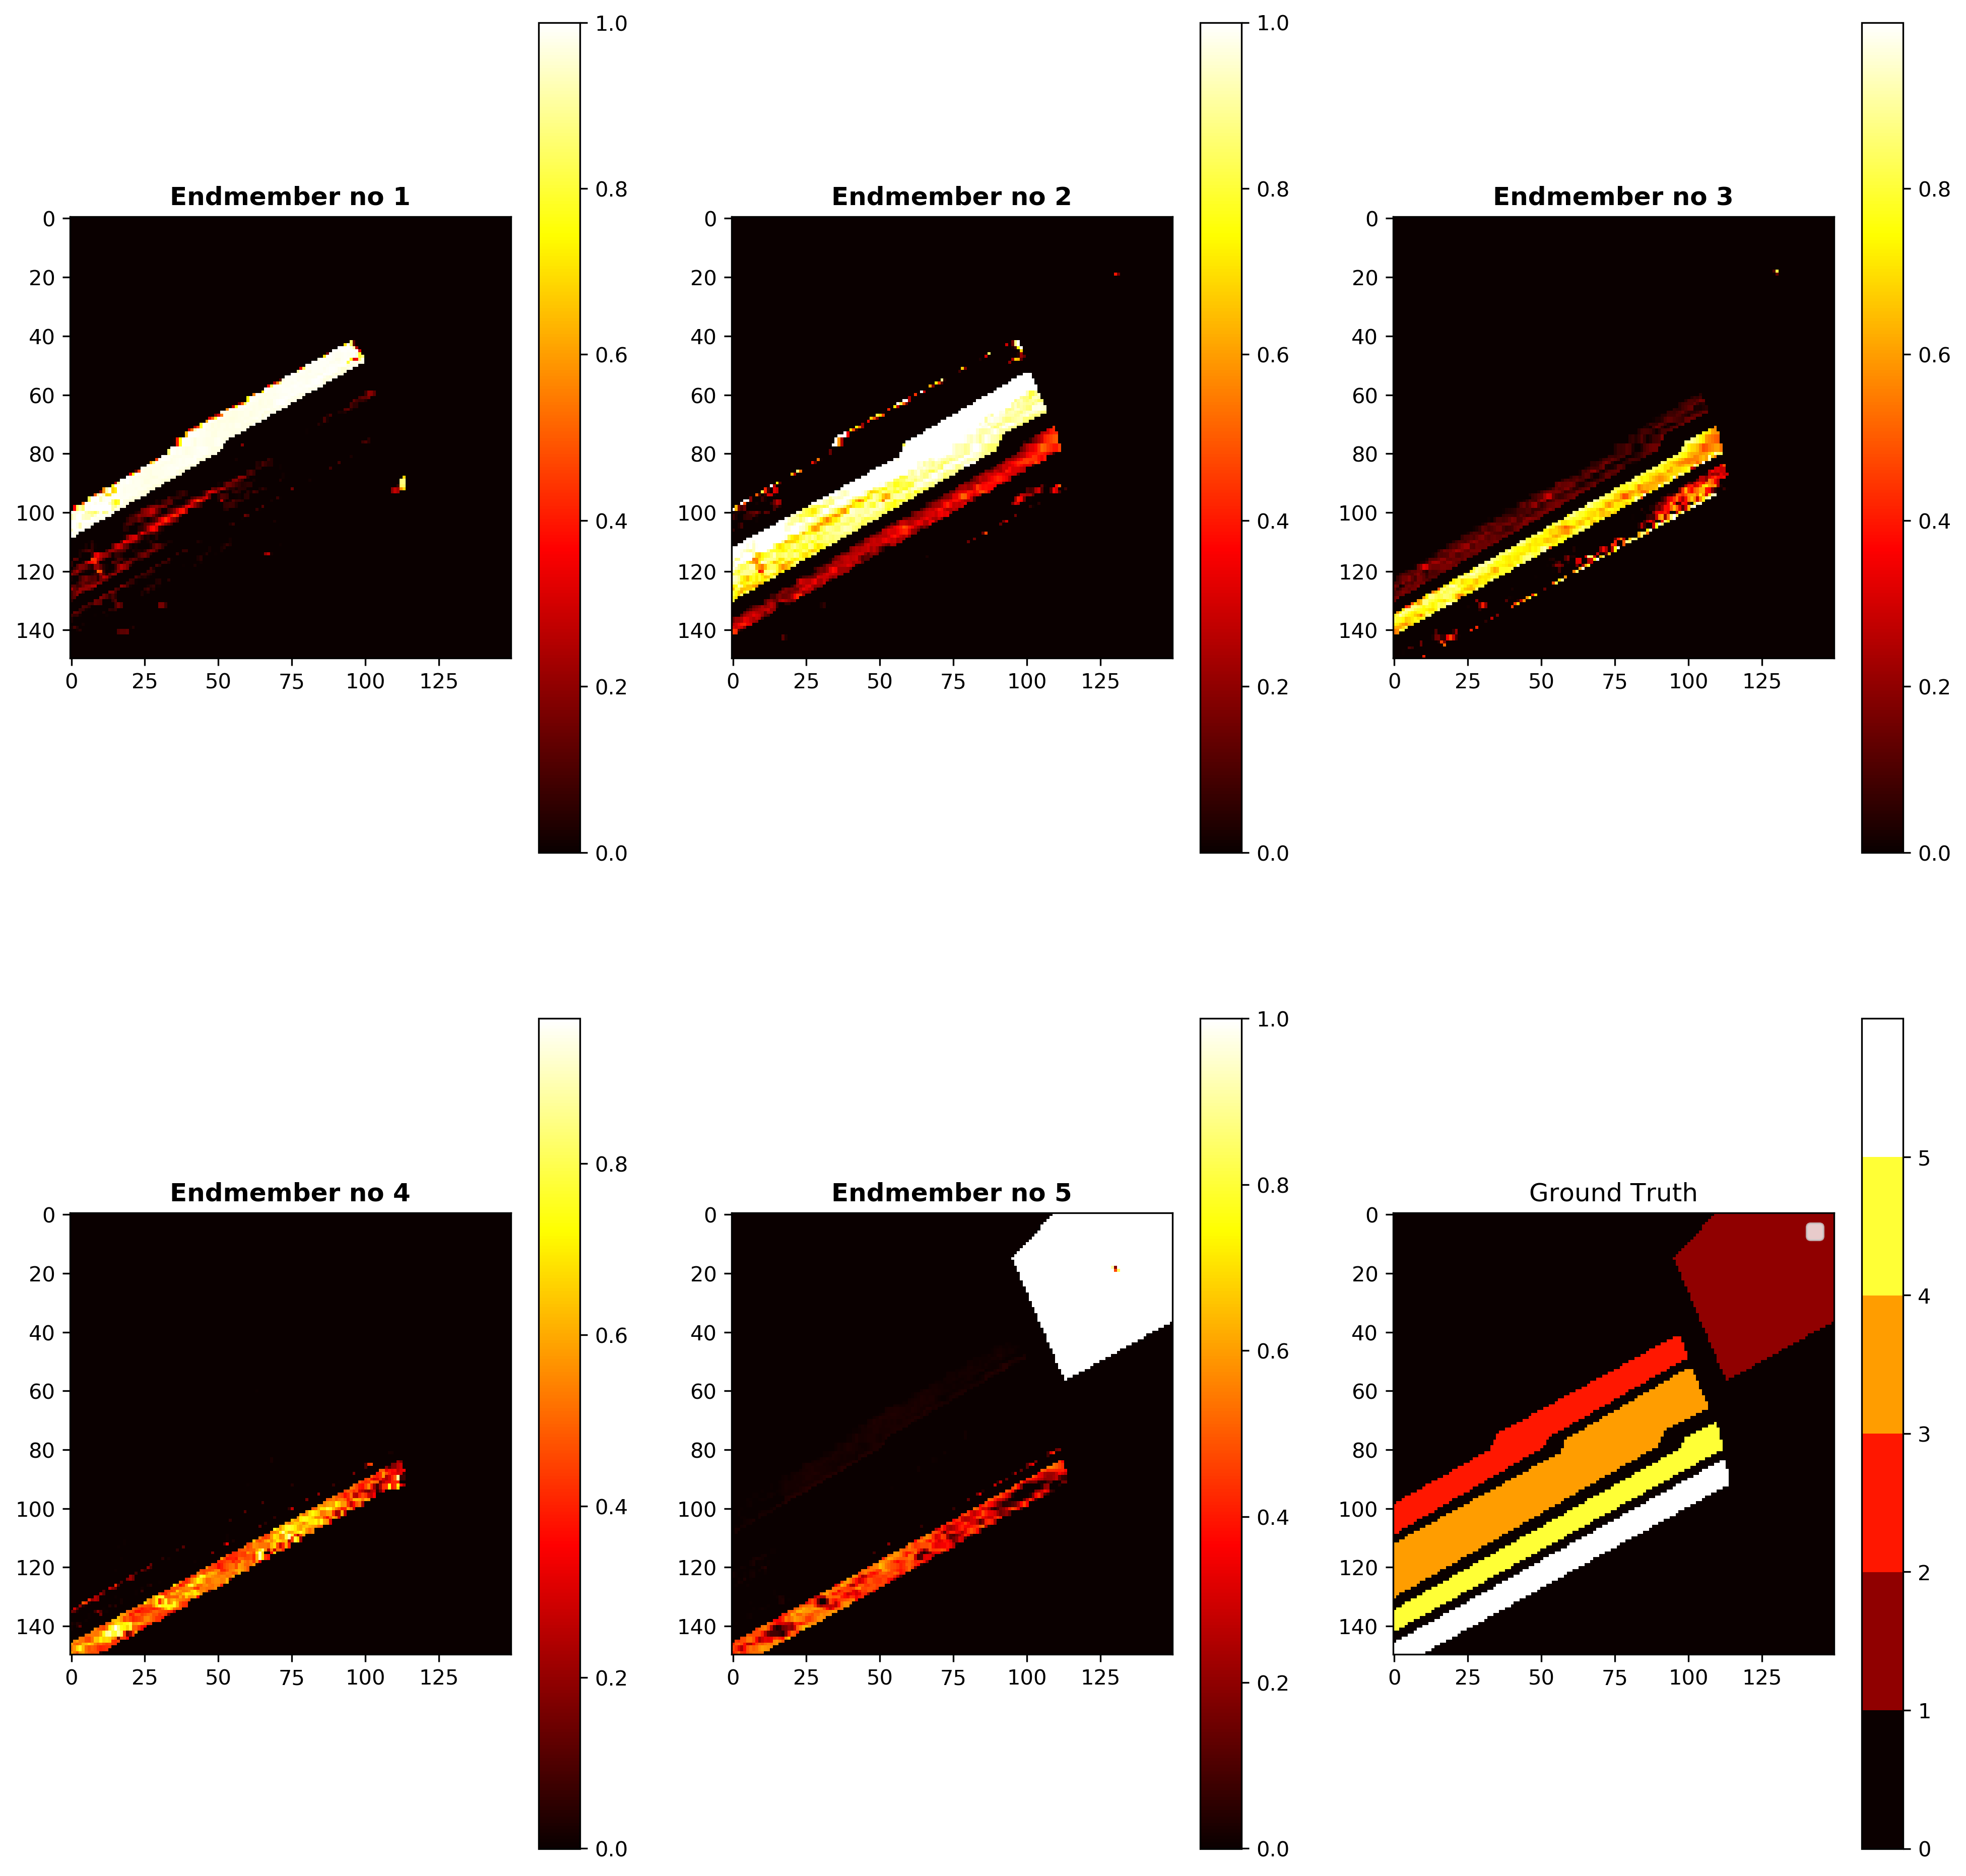

In [37]:
plot_final_maps()